### CH5.3.3 Image to Image RAG

In [1]:
# Step1. 필요 패키지 설치
%pip install wikipedia

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from dotenv import load_dotenv # 환경 변수 설정
load_dotenv()

True

In [ ]:
# Step2. 위키피디아에서 이미지 파일 저장 및 문서 로드

from pathlib import Path
import urllib.request, wikipedia

def download_wiki_images(titles, # 저장 검색어 리스트
                         out_dir="./data_image/wikipedia_images", # 이미지 파일 저장 경로
                         max_per_page=10): # 각 위키피디아 페이지에서 몇장까지 이미지 저장할지
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    saved, uid = [], 0
    for t in titles:
        try:
            pg = wikipedia.page(t)              # 위키백과 페이지 가져오기
        except:
            continue
        n = 0
        for url in pg.images:                   # 이미지 URL 목록 순회
            if url.lower().endswith((".jpg",".jpeg",".png")):
                uid += 1; p = out / f"{uid}.jpg"
                try:
                    urllib.request.urlretrieve(url, p)  # 다운로드
                    saved.append(str(p)); n += 1
                    if n >= max_per_page: break
                except:
                    uid -= 1
    return saved

In [8]:
# 검색어에 따른 이미지 파일 다운로드
titles = ["Tesla Model S", "피아노", "현대자동차", "vincent van gogh", "쇼팽"]
files = download_wiki_images(titles=titles, # 검색어 설정
                             out_dir="./data_image/wikipedia_images", # 저장 경로 설정
                             max_per_page=10) # 각 페이지에서 10장씩 저장

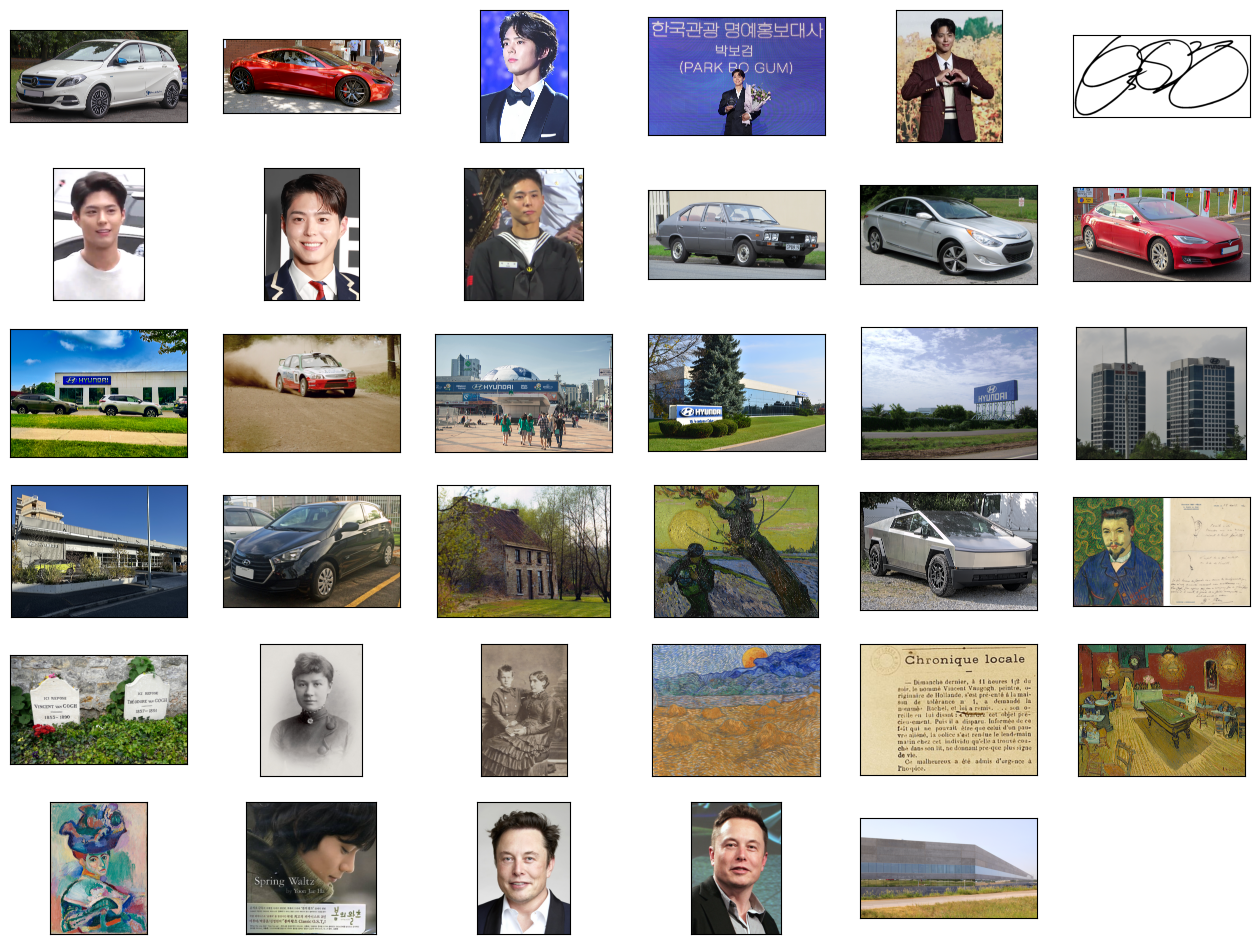

In [7]:
# 이미지 출력 코드
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./data_image/wikipedia_images"):
    image_paths.append(str(os.path.join("./data_image/wikipedia_images", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 12))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(6, 6, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 35:
                break

plot_images(image_paths)

In [ ]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader("./data_image/wikipedia_images").load_data()
print('이미지의 개수 : ', len(documents))

이미지의 개수 :  38


In [ ]:
# Step3. 쿼드런트 데이터베이스 구성 및 벡터스토어 설정

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # 손상된 이미지를 로드하도록 설정
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import StorageContext
import qdrant_client

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="./index/ch05_3_3_qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [ ]:
# Step4. 멀티모달 인덱스 생성 및 로드
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
index = MultiModalVectorStoreIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
)
index.storage_context.persist(persist_dir="./index/ch05_3_3_qdrant_img_db")

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\llama_index\vector_stores\qdrant\base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [5]:
from llama_index.core import load_index_from_storage
# 저장된 StorageContext 로드

storage_context = StorageContext.from_defaults(
    persist_dir="./index/ch05_3_3_qdrant_img_db",
    vector_store=text_store,
    image_store=image_store
)

# 저장된 인덱스 로드
index = load_index_from_storage(storage_context)

2025-09-24 19:17:50,996 - INFO - Loading all indices.


Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_3_qdrant_img_db\docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_3_qdrant_img_db\index_store.json.


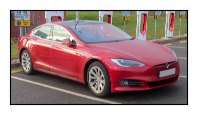

In [ ]:
# Step5. 이미지로 검색하기
input_img_path = "./data_image/image_input/red_car.jpg" # 입력할 이미지 확인
plot_images([input_img_path])

Node ID: eb7343e4-ffc6-435f-adb4-4c9d6e0bf195
Text:
Score:  1.000

Node ID: 4a452570-6cf6-40d8-b445-4e07e48d5e24
Text:
Score:  0.800

Node ID: ba38dd1a-cb41-49b5-b113-fe1655051e24
Text:
Score:  0.783

Node ID: 4e45feba-bc61-48b0-88f8-0dfbe6a60ab5
Text:
Score:  0.748



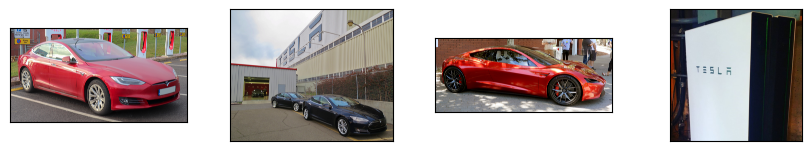

In [ ]:
# 리트리버 엔진 초기화
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# 입력 한 이미지로 유사 이미지 반환하기
retrieval_results = retriever_engine.image_to_image_retrieve(input_img_path)

# 검색 결과 스코어 및 노드 정보 출력하기
retrieved_images = []
for res in retrieval_results:
    print(res)
    retrieved_images.append(res.node.metadata["file_path"])

# 검색 된 이미지 출력하기
plot_images(retrieved_images)

In [ ]:
# Step6. 쿼리 엔진 객체 생성 및 응답 생성
from llama_index.core import PromptTemplate
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", max_new_tokens=1500
)

qa_tmpl_str = (
    "주어진 이미지에 따라 질문에 응답하시오.\n"
    "Prompt: {query_str}\n"
    "Response: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, 
    image_qa_template=qa_tmpl,
    similarity_top_k=3, 
    image_similarity_top_k=4
)

query_str = "제가 입력한 그림과 검색 된 그림에 대해 설명해주시길 바랍니다"
response = query_engine.image_query(input_img_path, query_str)
print(response)

C:\Users\USER\AppData\Local\Temp\ipykernel_3740\1190095308.py:4: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(
2025-09-24 19:19:46,423 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


물론입니다. 주어진 이미지들을 설명해드리겠습니다.

1. **첫 번째 이미지**: 빨간색 테슬라 차량이 전기차 충전소에 주차되어 있는 모습입니다. 차량은 테슬라 모델 S로 보이며, 주변에 테슬라 전용 충전기가 설치되어 있습니다.

2. **두 번째 이미지**: 두 대의 검은색 테슬라 차량이 테슬라 공장 외부에 주차되어 있는 모습입니다. 공장 건물에는 큰 테슬라 로고가 보입니다.

3. **세 번째 이미지**: 빨간색 테슬라 로드스터 차량이 전시되어 있는 모습입니다. 이 차량은 스포츠카 스타일로 디자인되어 있습니다.

4. **네 번째 이미지**: 테슬라의 에너지 저장 장치인 파워월(Powerwall)입니다. 이 장치는 가정용 에너지 저장 솔루션으로, 전력을 저장하고 필요할 때 사용할 수 있게 해줍니다.

이 이미지들은 테슬라의 다양한 제품과 관련된 모습을 보여주고 있습니다.
